In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
!pip install lightgbm
!pip install catboost

In [91]:
!pip install mlxtend

     ---------------------------------------- 1.3/1.3 MB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

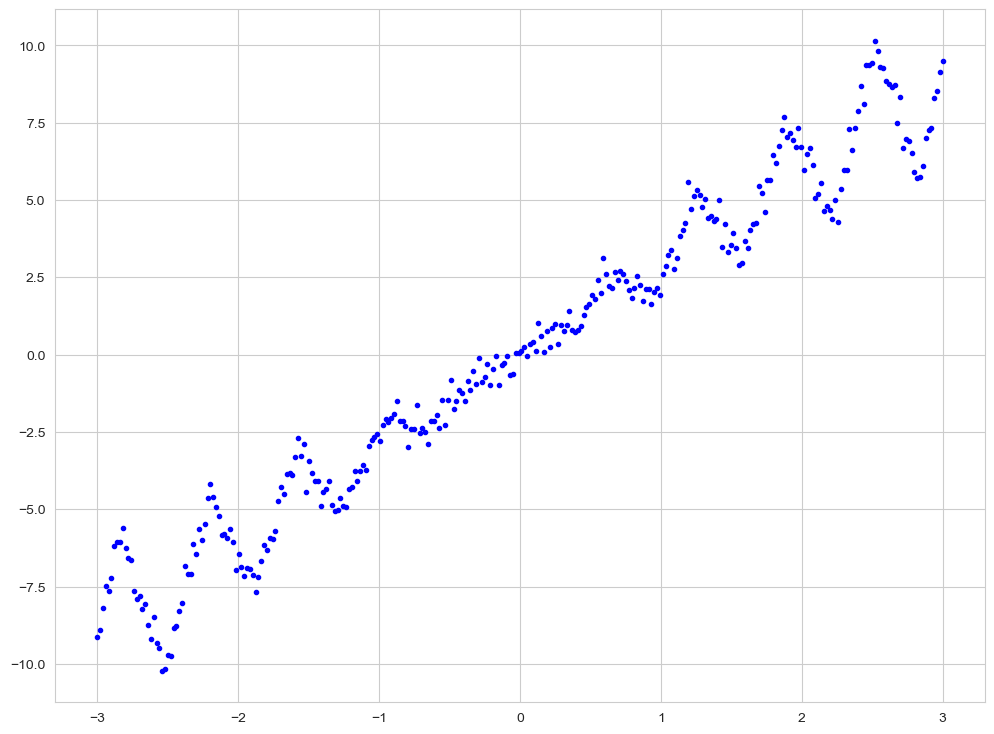

In [5]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [6]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x, y_pred, linewidth=2, label=r"$\hat{y}$", color = 'violet')

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

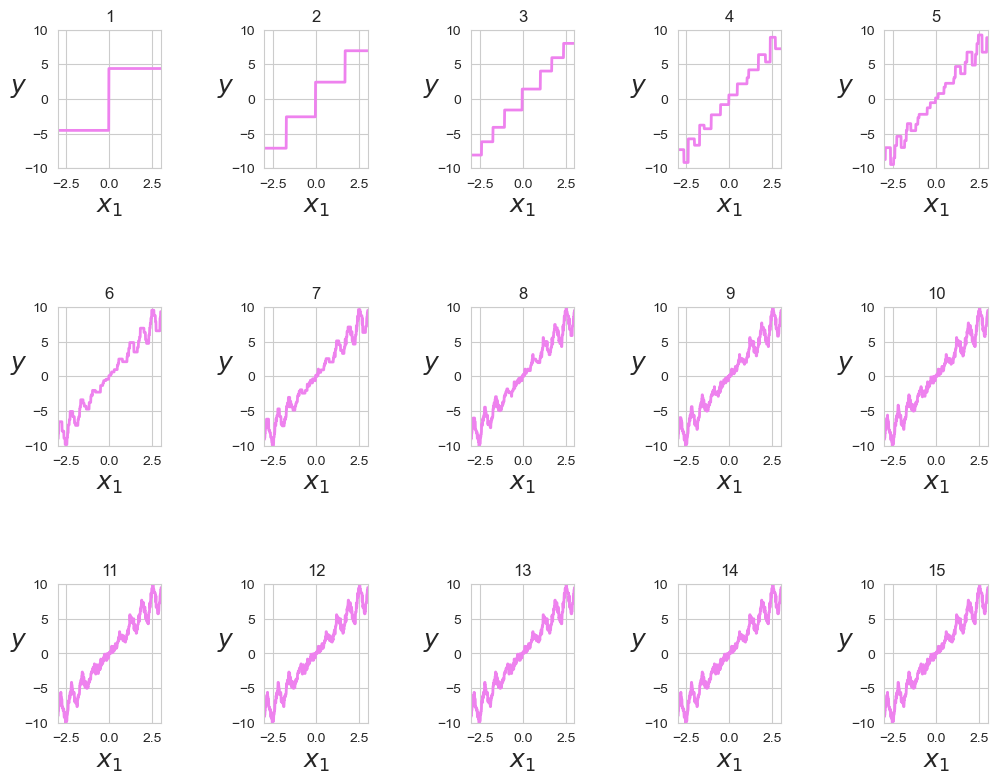

In [8]:
for depth in range(1, 16):
    regression = DecisionTreeRegressor(max_depth=depth).fit(X, y)
    plt.subplot(3, 5, depth)
    plot_regression_predictions(regression, X, y)
    plt.title(depth)
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

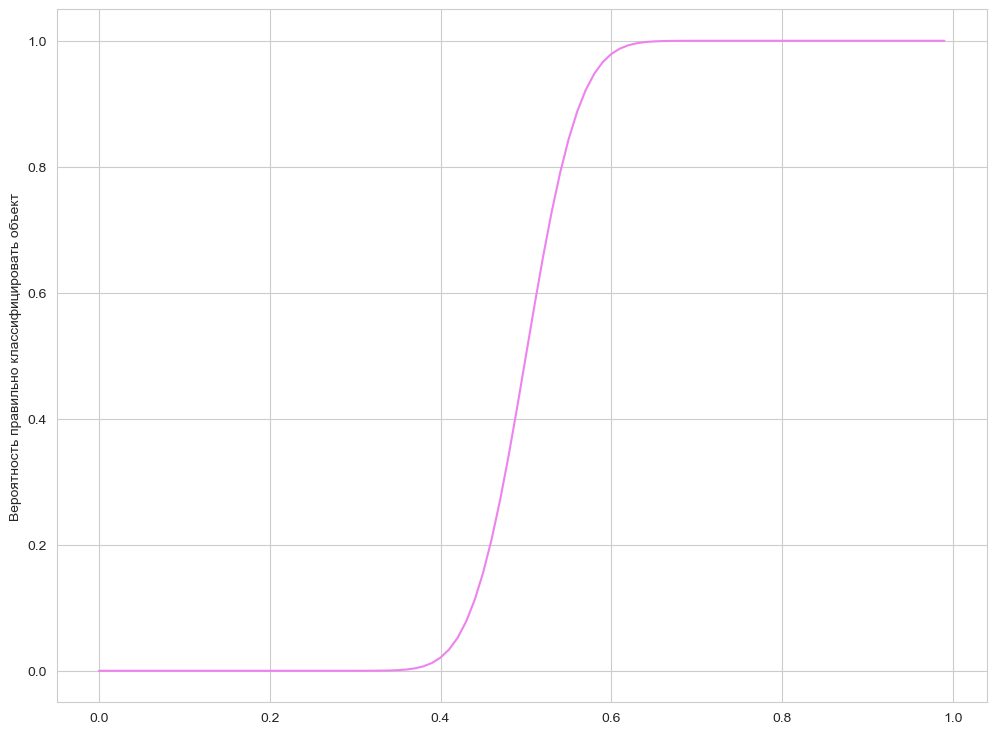

In [10]:
probability = []
step = np.arange(0, 1, 0.01)
for p in step:
    sum_p = 0
    for i in range(51, 102):
        sum_p += math.comb(101, i)*(p**i)*((1-p)**(101-i))
    probability.append(sum_p)
plt.plot(step, probability, color="violet")
plt.xlabel('')
plt.ylabel('Вероятность правильно классифицировать объект');

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [11]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

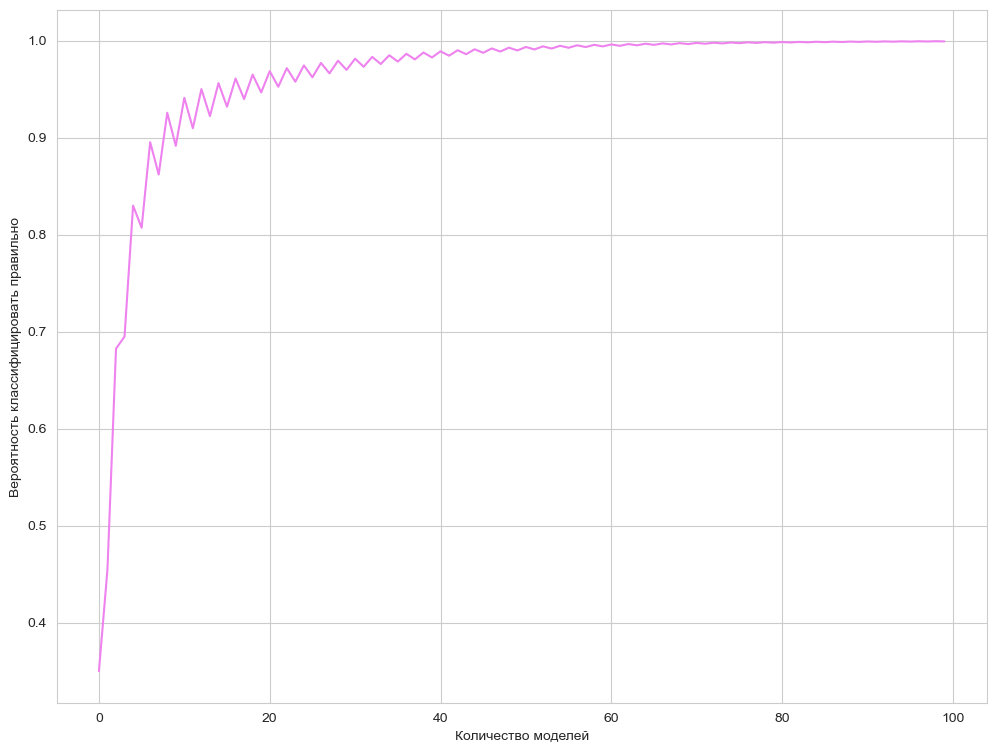

In [12]:
probability = []
for i in range(1, 101):
    sum = 0
    for j in range(i//2, i):
        res = math.comb(i,j)*(0.65**j)*((1-0.65)**(i-j))
        sum += res
    probability.append(sum)
plt.plot(probability, color="violet")
plt.xlabel('Количество моделей')
plt.ylabel('Вероятность классифицировать правильно');

Опишите ваши наблюдения:

* 100 класссификаторов при перостности 0.6 предсказывают класс с вероятностью близкой к 1
* В целом, 50 классчификаторов с вероятностью 0.65 предсказывают с точностью близкой к 1

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [13]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range (0, self.n_estimators-1):
            np.random.seed(self.random_state + i) #Зафиксируйте генератор случайных чисел
            feat_ids = np.random.choice(X.shape[1], size=self.max_features, replace=False) #выберите max_features признаков без возвращения
            self.feat_ids_by_tree.append(feat_ids) #сохраните список выбранных признаков
            pseudoselection = np.random.choice((X.shape[0]), size=X.shape[0], replace=True) #создайте псевдовыборку
            classifier = DecisionTreeClassifier(max_depth=self.max_depth,
                                                max_features = self.max_features,
                                                random_state=self.random_state + i)
            classifier.fit(X[pseudoselection][:, feat_ids], y[pseudoselection])
            self.trees.append(classifier)
            
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred = np.zeros((X.shape[0], len(self.classes_)))        
        for tree, feature in zip(self.trees, self.feat_ids_by_tree):          
            y_pred += tree.predict_proba(X[:, feature])
        return y_pred / self.n_estimators
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [14]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

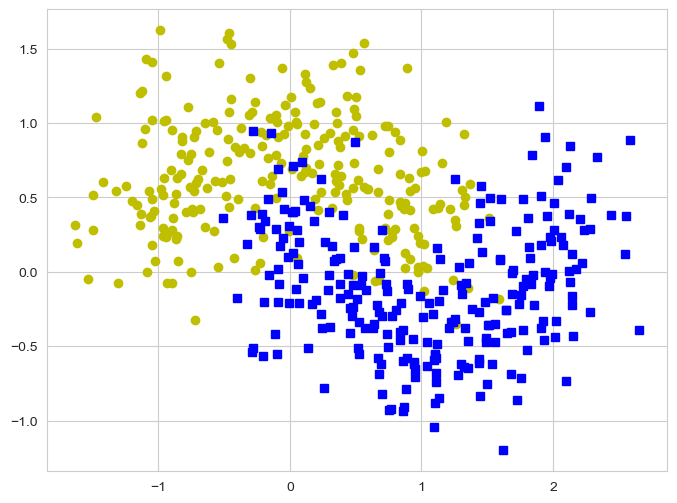

In [15]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [16]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

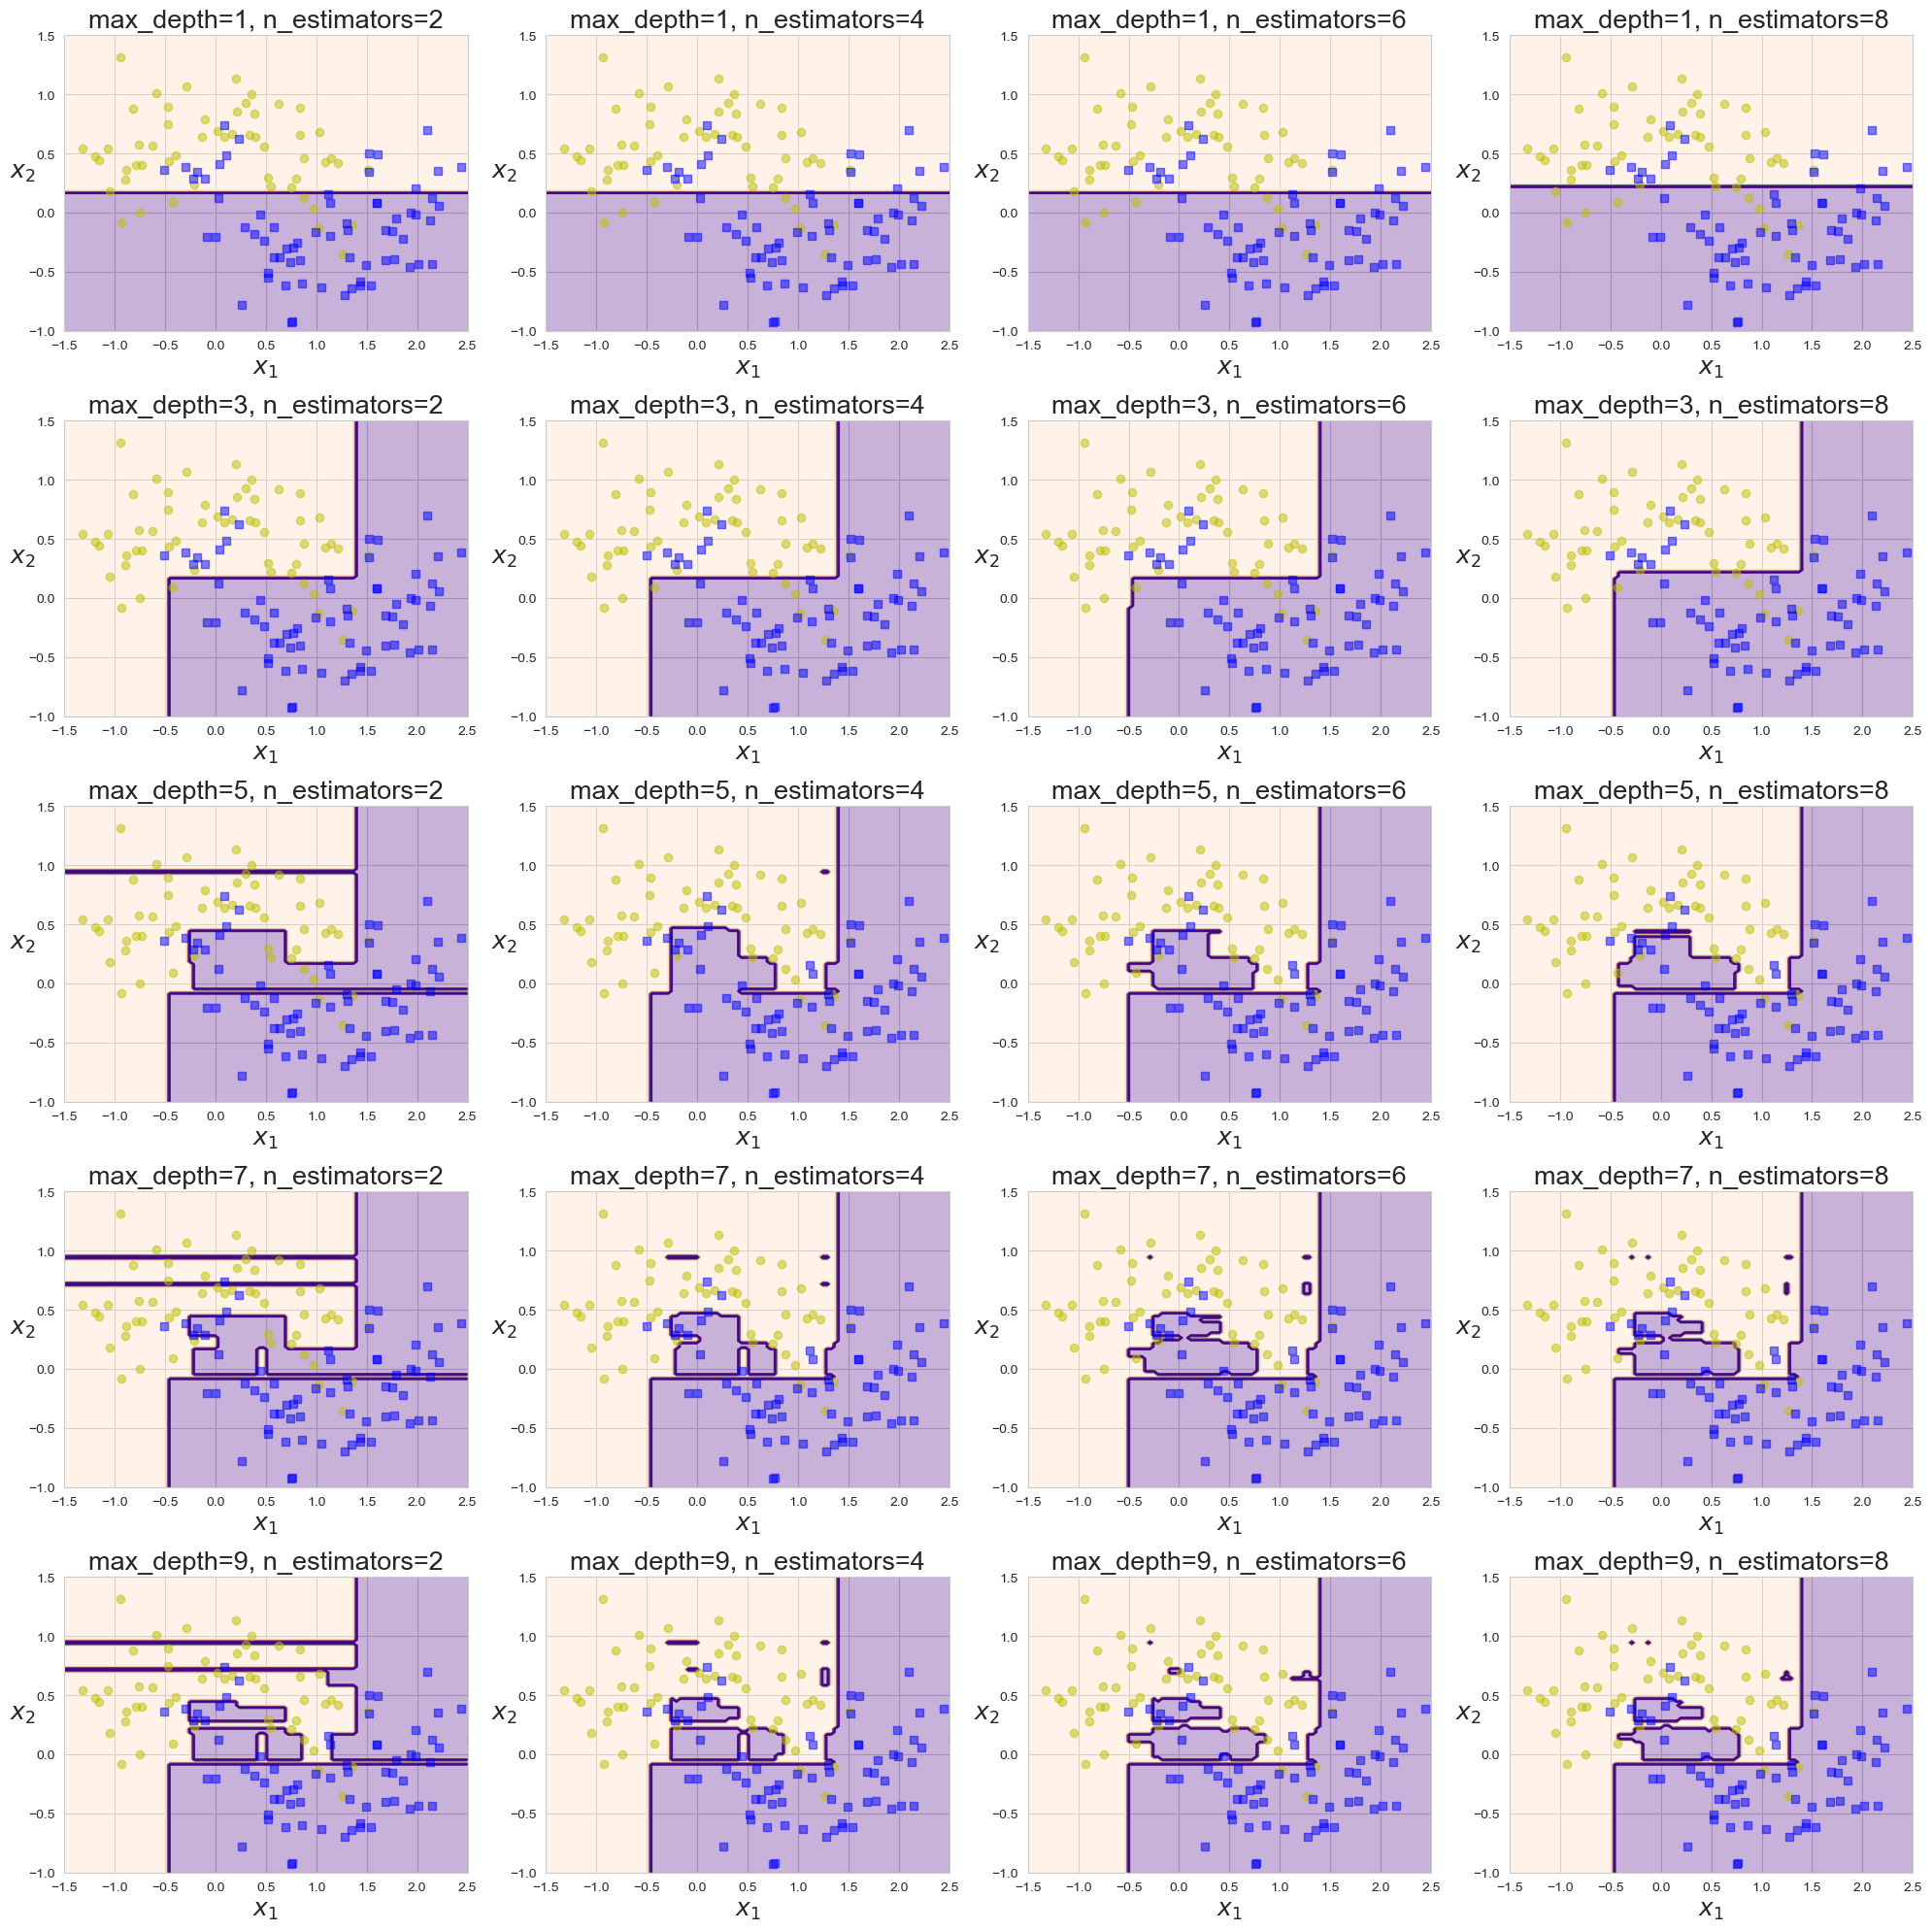

<Figure size 2000x1000 with 0 Axes>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
plot_place=1
plt.figure(figsize=(20, 20))
for depth in range(1, 10, 2):
    for estim in range(2, 10, 2):
        classifier = RandomForestClassifierCustom(max_depth=depth, max_features=2, n_estimators=estim)
        classifier.fit(X_train, y_train)
        plt.subplot(5, 4, plot_place)
        plt.tight_layout()
        plot_decision_boundary(classifier, X_test, y_test)
        plt.title(f'max_depth={depth}, n_estimators={estim}', fontsize=19.5)
        plot_place += 1
plt.figure(figsize=(20,10))
plt.show();

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [18]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

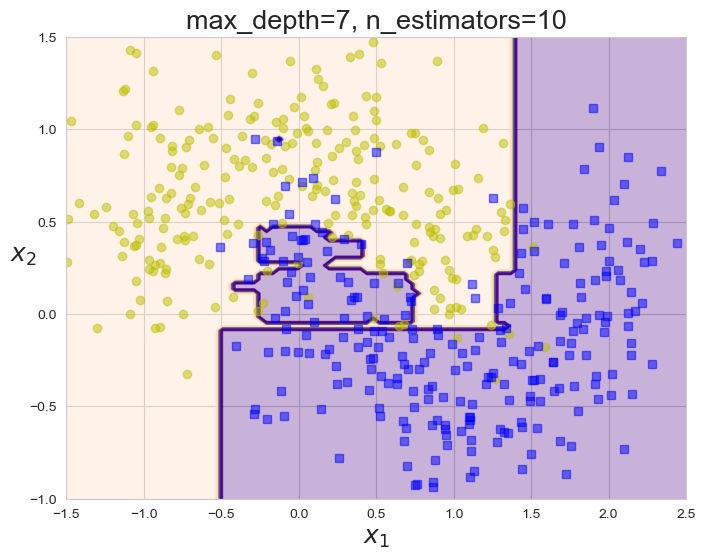

In [19]:
plt.figure(figsize=(8, 6))
classifier = RandomForestClassifierCustom(max_depth=7, max_features=2, n_estimators=10)
classifier.fit(X_train, y_train)
plot_decision_boundary(classifier, X, y)
plt.title(f'max_depth=7, n_estimators=10', fontsize=19.5)
plt.show()

Вроде выглядит прилично

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [20]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [21]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

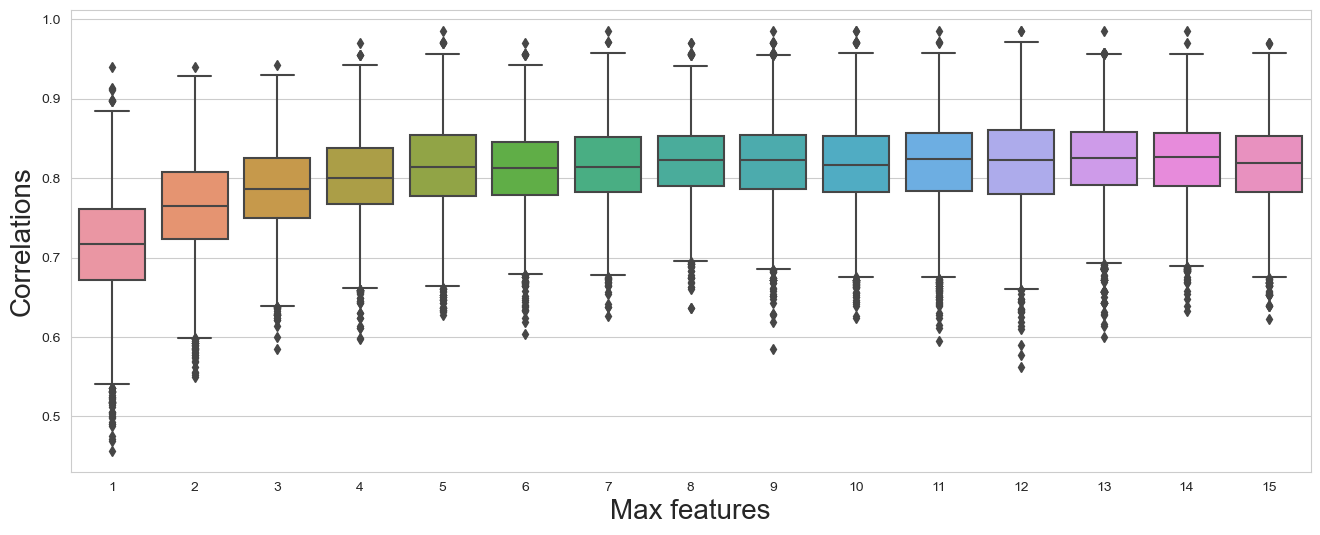

In [23]:
corr = []
for features in range(1, 16):
    classifier = RandomForestClassifier(max_features=features)
    classifier.fit(X_train, y_train)
    corr.append(base_model_pair_correlation(classifier, X_test))
    
plt.figure(figsize = (16, 6))
sns.boxplot(data=pd.DataFrame(np.array(corr).T, columns=range(1, 16)))
plt.xlabel('Max features', fontsize=20)
plt.ylabel('Correlations', fontsize=20)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

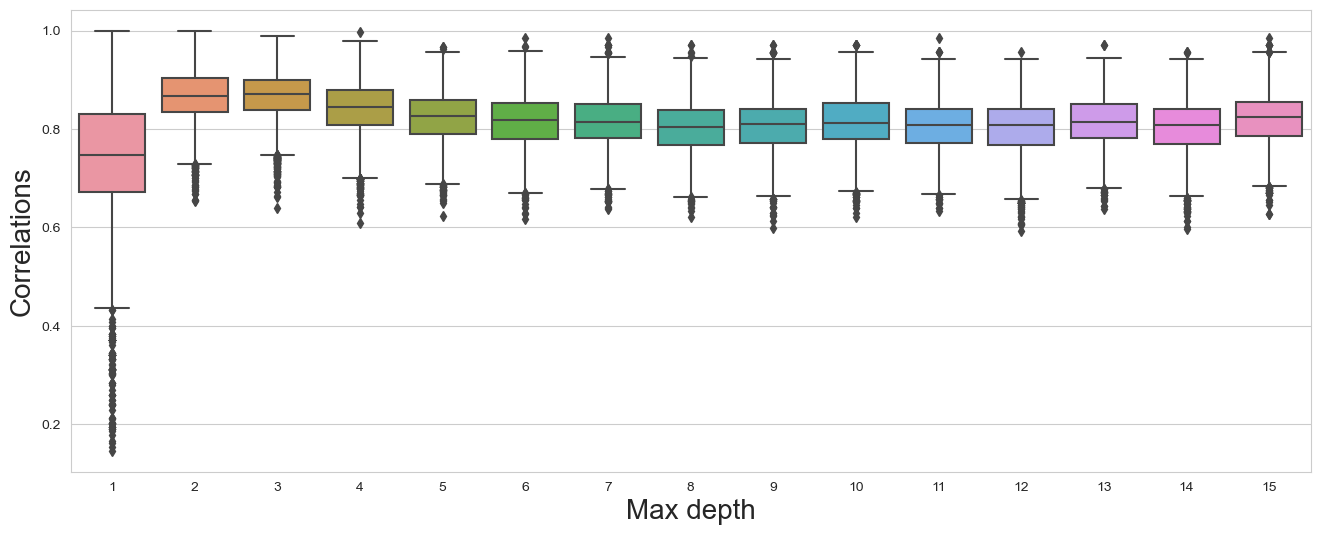

In [25]:
corr = []
for depth in range(1, 16):
    classifier = RandomForestClassifier(max_depth=depth)
    classifier.fit(X_train, y_train)
    corr.append(base_model_pair_correlation(classifier, X_test))
    
plt.figure(figsize = (16, 6))
sns.boxplot(data=pd.DataFrame(np.array(corr).T, columns=range(1, 16)))
plt.xlabel('Max depth', fontsize=20)
plt.ylabel('Correlations', fontsize=20)
plt.show()

Опишите ваши наблюдения:

* корреляция увеличивается с увеличением числом фичей, но ачиная с 6 особо не меняется
* с учеличением глкбины корреляция возрестает, но начиная с 4 - снижается. Поэтому оптимальным можно считать глубину 3-4

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [5]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [6]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [7]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [9]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [32]:
voting_soft.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8134894007824365),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941164),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.3133294966283545),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.7153743909950713),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.2820135356695378),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7875690140798687),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8282760696670941),


In [33]:
voting_hard.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8134894007824365),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941164),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.3133294966283545),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.7153743909950713),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.2820135356695378),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7875690140798687),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8282760696670941),


In [14]:
base_models = [("DT", dt), 
               ("RF", rf), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("XGB", xgb),
               ("LR", lr), 
               ("NB", nb)]
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)

scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")


VotingClassifier: 0.8550318922749822


Ля, это все ручками сделано

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [15]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [17]:
print(data['State'].value_counts()) #их прям что-то много, лучше их проигнорировать

WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: State, dtype: int64


In [18]:
label_encoder = LabelEncoder()
data["Int'l Plan"] = label_encoder.fit_transform(data["Int'l Plan"])
data["VMail Plan"] = label_encoder.fit_transform(data["VMail Plan"])
data["Churn?"] = label_encoder.fit_transform(data["Churn?"])
X = data.copy().drop(['State', 'Phone', 'Churn?'], axis = 1)
y = data["Churn?"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [31]:
xb = xgboost.XGBClassifier()
parameters_xb = {
    'max_depth': range(2, 20, 2),
    'learning_rate': np.linspace(0, 1, 10),
    'gamma': np.linspace(0, 1, 10),
    'eta': np.linspace(0, 1, 10)
}
grid_search = GridSearchCV(
    estimator=xb,
    param_grid=parameters_xb,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9000 candidates, totalling 45000 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
             param_grid={'eta': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'gamma': array([0.        , 0.11111111, 0.22222222, 0.

Подбор дико долгий и неоптимальный, если честно, а скор не сказать, что шикарный

In [32]:
print(grid_search.best_params_)

{'eta': 0.0, 'gamma': 0.6666666666666666, 'learning_rate': 0.7777777777777777, 'max_depth': 14}


In [48]:
xb = xgboost.XGBClassifier(gamma=0.666,
                           learning_rate = 0.777, 
                           max_depth = 6, #почти такой же скор, как и для 14, но меньше вероятность переобучиться
                           n_estimators = 60)
xb.fit(X_train, y_train,
        eval_metric='auc',
        eval_set=[(X_test, y_test)])
scores = cross_val_score(xb, X_train, y_train, cv=3, scoring="f1")
print(f"{xb.__class__.__name__}: {scores.mean()}")

[0]	validation_0-auc:0.88242
[1]	validation_0-auc:0.88622
[2]	validation_0-auc:0.88793
[3]	validation_0-auc:0.88556
[4]	validation_0-auc:0.87818
[5]	validation_0-auc:0.90537
[6]	validation_0-auc:0.90628
[7]	validation_0-auc:0.90284
[8]	validation_0-auc:0.89385
[9]	validation_0-auc:0.89554
[10]	validation_0-auc:0.89439
[11]	validation_0-auc:0.89136
[12]	validation_0-auc:0.89069
[13]	validation_0-auc:0.89149
[14]	validation_0-auc:0.89040
[15]	validation_0-auc:0.89532
[16]	validation_0-auc:0.88932
[17]	validation_0-auc:0.88720
[18]	validation_0-auc:0.88637
[19]	validation_0-auc:0.88620
[20]	validation_0-auc:0.88543
[21]	validation_0-auc:0.88558
[22]	validation_0-auc:0.88414
[23]	validation_0-auc:0.88414
[24]	validation_0-auc:0.88414
[25]	validation_0-auc:0.88414
[26]	validation_0-auc:0.88414
[27]	validation_0-auc:0.88414
[28]	validation_0-auc:0.88414
[29]	validation_0-auc:0.88414
[30]	validation_0-auc:0.88414
[31]	validation_0-auc:0.88414
[32]	validation_0-auc:0.88414
[33]	validation_0-au

In [ ]:
print(grid_search_lg_rf.best_params_)

In [97]:
lg_rf = lightgbm.LGBMClassifier(boosting_type="rf",
                               num_leaves=200,
                               n_estimators=15,
                               min_child_weight=2,
                               subsample=0.69, 
                               subsample_freq=3,
                               min_split_gain=0.2)
lg_rf.fit(X_train, y_train,
        eval_metric='auc',
        eval_set=[(X_test, y_test)])
scores = cross_val_score(lg_rf, X_train, y_train, cv=3, scoring="f1")
print(f"{lg_rf.__class__.__name__}: {scores.mean()}")

[1]	valid_0's auc: 0.856757	valid_0's binary_logloss: 0.265821
[2]	valid_0's auc: 0.856757	valid_0's binary_logloss: 0.265821
[3]	valid_0's auc: 0.856757	valid_0's binary_logloss: 0.265821
[4]	valid_0's auc: 0.86638	valid_0's binary_logloss: 0.253098
[5]	valid_0's auc: 0.866663	valid_0's binary_logloss: 0.248581
[6]	valid_0's auc: 0.864629	valid_0's binary_logloss: 0.247402
[7]	valid_0's auc: 0.861619	valid_0's binary_logloss: 0.246121
[8]	valid_0's auc: 0.862914	valid_0's binary_logloss: 0.246454
[9]	valid_0's auc: 0.862796	valid_0's binary_logloss: 0.247474
[10]	valid_0's auc: 0.863197	valid_0's binary_logloss: 0.246709
[11]	valid_0's auc: 0.866754	valid_0's binary_logloss: 0.24641
[12]	valid_0's auc: 0.866198	valid_0's binary_logloss: 0.246382
[13]	valid_0's auc: 0.868597	valid_0's binary_logloss: 0.245116
[14]	valid_0's auc: 0.869162	valid_0's binary_logloss: 0.244276
[15]	valid_0's auc: 0.869938	valid_0's binary_logloss: 0.243746
LGBMClassifier: 0.7582988182988184


In [113]:
cat_boost = catboost.CatBoostClassifier(eval_metric='AUC', 
                                        iterations=200, 
                                        depth=7, 
                                        learning_rate=0.6,
                                        scale_pos_weight=0.7)
cat_boost.fit(X_train, y_train, eval_set=(X_test, y_test))
scores = cross_val_score(cat_boost, X_train, y_train, cv=3, scoring="f1")
print(f"{cat_boost.__class__.__name__}: {scores.mean()}")

0:	test: 0.6585395	best: 0.6585395 (0)	total: 3.79ms	remaining: 755ms
1:	test: 0.8796610	best: 0.8796610 (1)	total: 7.75ms	remaining: 767ms
2:	test: 0.8693630	best: 0.8796610 (1)	total: 10.9ms	remaining: 718ms
3:	test: 0.8739602	best: 0.8796610 (1)	total: 14.3ms	remaining: 699ms
4:	test: 0.8786030	best: 0.8796610 (1)	total: 17.5ms	remaining: 682ms
5:	test: 0.8809837	best: 0.8809837 (5)	total: 20.7ms	remaining: 670ms
6:	test: 0.8792779	best: 0.8809837 (5)	total: 24.1ms	remaining: 665ms
7:	test: 0.8790590	best: 0.8809837 (5)	total: 27.5ms	remaining: 659ms
8:	test: 0.8783840	best: 0.8809837 (5)	total: 30.7ms	remaining: 652ms
9:	test: 0.8805276	best: 0.8809837 (5)	total: 34ms	remaining: 646ms
10:	test: 0.8810566	best: 0.8810566 (10)	total: 37.4ms	remaining: 642ms
11:	test: 0.8777729	best: 0.8810566 (10)	total: 40.8ms	remaining: 639ms
12:	test: 0.8780830	best: 0.8810566 (10)	total: 44.1ms	remaining: 634ms
13:	test: 0.8813120	best: 0.8813120 (13)	total: 47.3ms	remaining: 628ms
14:	test: 0.88

121:	test: 0.8909625	best: 0.8986245 (40)	total: 400ms	remaining: 256ms
122:	test: 0.8910537	best: 0.8986245 (40)	total: 404ms	remaining: 253ms
123:	test: 0.8915280	best: 0.8986245 (40)	total: 407ms	remaining: 249ms
124:	test: 0.8914733	best: 0.8986245 (40)	total: 411ms	remaining: 246ms
125:	test: 0.8915645	best: 0.8986245 (40)	total: 415ms	remaining: 244ms
126:	test: 0.8923125	best: 0.8986245 (40)	total: 419ms	remaining: 241ms
127:	test: 0.8922030	best: 0.8986245 (40)	total: 422ms	remaining: 237ms
128:	test: 0.8923125	best: 0.8986245 (40)	total: 425ms	remaining: 234ms
129:	test: 0.8911449	best: 0.8986245 (40)	total: 429ms	remaining: 231ms
130:	test: 0.8916557	best: 0.8986245 (40)	total: 432ms	remaining: 227ms
131:	test: 0.8915463	best: 0.8986245 (40)	total: 435ms	remaining: 224ms
132:	test: 0.8917652	best: 0.8986245 (40)	total: 438ms	remaining: 221ms
133:	test: 0.8917287	best: 0.8986245 (40)	total: 441ms	remaining: 217ms
134:	test: 0.8914003	best: 0.8986245 (40)	total: 444ms	remaining

113:	total: 321ms	remaining: 242ms
114:	total: 324ms	remaining: 240ms
115:	total: 327ms	remaining: 237ms
116:	total: 331ms	remaining: 234ms
117:	total: 333ms	remaining: 232ms
118:	total: 336ms	remaining: 229ms
119:	total: 339ms	remaining: 226ms
120:	total: 342ms	remaining: 223ms
121:	total: 344ms	remaining: 220ms
122:	total: 347ms	remaining: 217ms
123:	total: 350ms	remaining: 215ms
124:	total: 353ms	remaining: 212ms
125:	total: 356ms	remaining: 209ms
126:	total: 358ms	remaining: 206ms
127:	total: 361ms	remaining: 203ms
128:	total: 364ms	remaining: 200ms
129:	total: 367ms	remaining: 198ms
130:	total: 370ms	remaining: 195ms
131:	total: 372ms	remaining: 192ms
132:	total: 375ms	remaining: 189ms
133:	total: 378ms	remaining: 186ms
134:	total: 381ms	remaining: 183ms
135:	total: 384ms	remaining: 181ms
136:	total: 387ms	remaining: 178ms
137:	total: 390ms	remaining: 175ms
138:	total: 392ms	remaining: 172ms
139:	total: 395ms	remaining: 169ms
140:	total: 398ms	remaining: 167ms
141:	total: 401ms	re

172:	total: 522ms	remaining: 81.5ms
173:	total: 525ms	remaining: 78.5ms
174:	total: 529ms	remaining: 75.5ms
175:	total: 531ms	remaining: 72.5ms
176:	total: 535ms	remaining: 69.5ms
177:	total: 537ms	remaining: 66.4ms
178:	total: 540ms	remaining: 63.4ms
179:	total: 543ms	remaining: 60.3ms
180:	total: 546ms	remaining: 57.3ms
181:	total: 549ms	remaining: 54.3ms
182:	total: 551ms	remaining: 51.2ms
183:	total: 554ms	remaining: 48.2ms
184:	total: 557ms	remaining: 45.2ms
185:	total: 560ms	remaining: 42.1ms
186:	total: 563ms	remaining: 39.1ms
187:	total: 566ms	remaining: 36.1ms
188:	total: 568ms	remaining: 33.1ms
189:	total: 571ms	remaining: 30ms
190:	total: 574ms	remaining: 27ms
191:	total: 576ms	remaining: 24ms
192:	total: 579ms	remaining: 21ms
193:	total: 582ms	remaining: 18ms
194:	total: 584ms	remaining: 15ms
195:	total: 587ms	remaining: 12ms
196:	total: 590ms	remaining: 8.98ms
197:	total: 592ms	remaining: 5.98ms
198:	total: 595ms	remaining: 2.99ms
199:	total: 598ms	remaining: 0us
0:	total:

Оценка по среднему явно занижает мне баллы! Есть смотреть по максимуму, то результат явно лучше...


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [43]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

Я, когда у меня что-то получилось (или жду пока ты проверишь дз)

 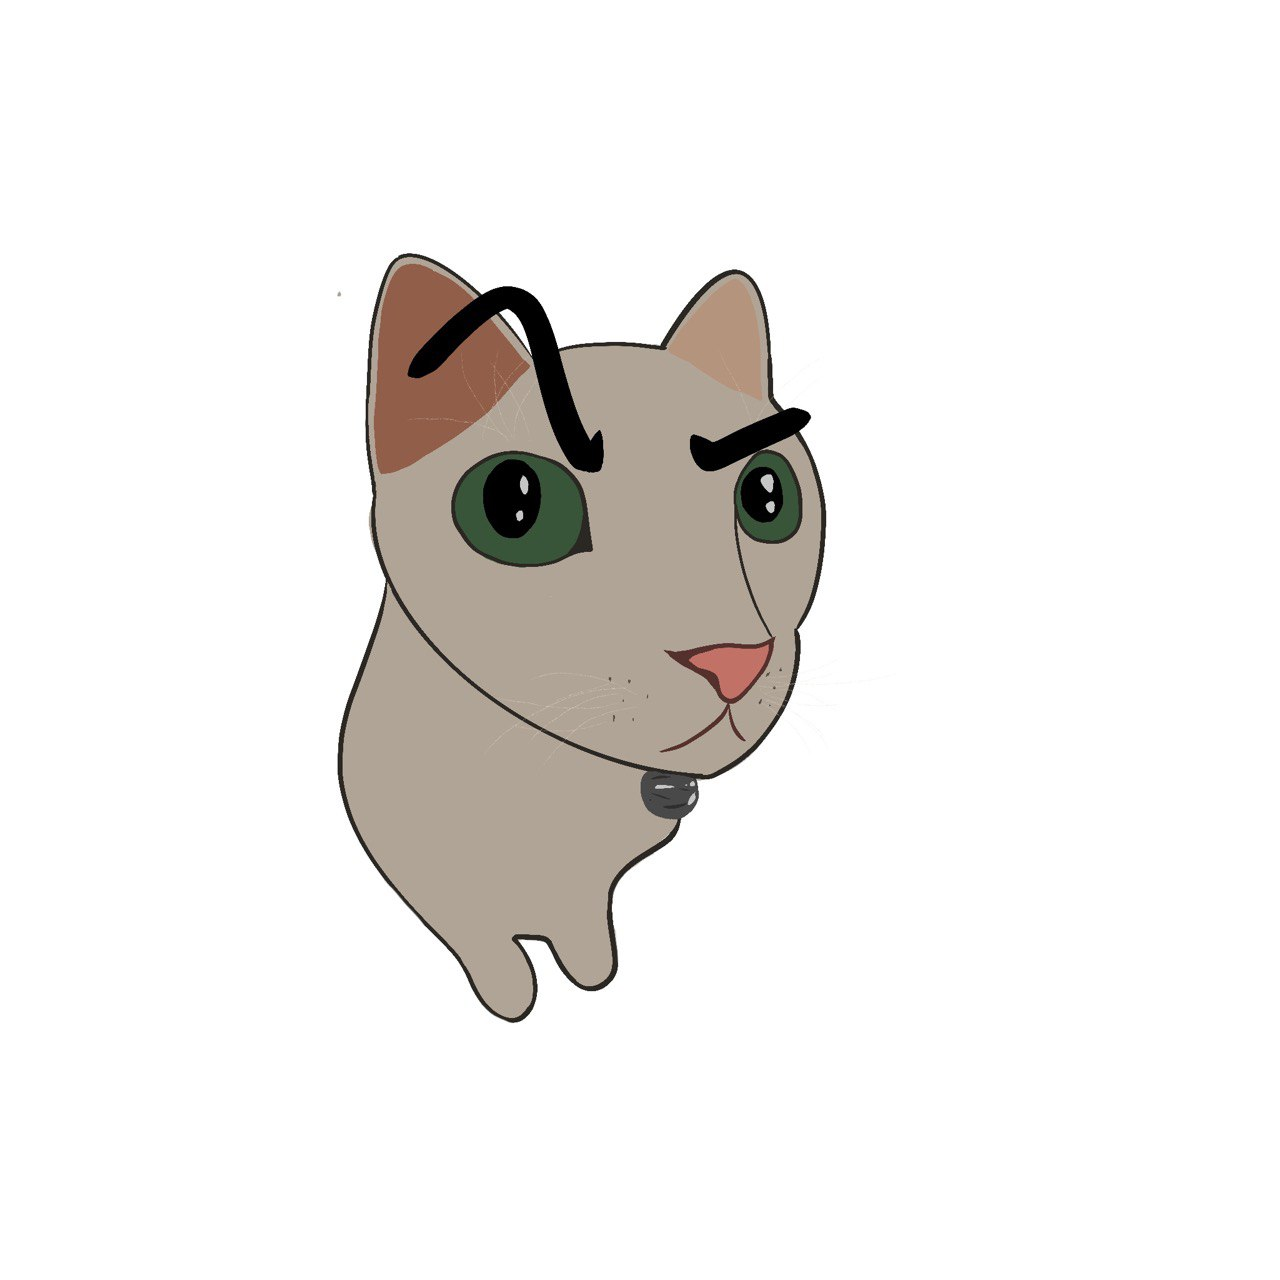

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**